# Contraceptive Method Choice
Lab Assignment Four: Extending Logistic Regression

**_Jake Oien, Seung Ki Lee, Jenn Le_**

## Data Preparation and Overview

### Class Variables

Dataset Source: https://archive.ics.uci.edu/ml/datasets/Contraceptive+Method+Choice

This dataset is a subset of the 1987 National Indonesia Contraceptive Prevalence Survey. The samples are married women who were either not pregnant or do not know if they were at the time of interview. The problem is to predict the current contraceptive method choice (no use, long-term methods, or short-term methods) of a woman based on her demographic and socio-economic characteristics.

1. Wife's age (numerical) 
2. Wife's education (categorical) 1=low, 2, 3, 4=high 
3. Husband's education (categorical) 1=low, 2, 3, 4=high 
4. Number of children ever born (numerical) 
5. Wife's religion (binary) 0=Non-Islam, 1=Islam 
6. Wife's now working? (binary) 0=Yes, 1=No 
7. Husband's occupation (categorical) 1, 2, 3, 4 
8. Standard-of-living index (categorical) 1=low, 2, 3, 4=high 
9. Media exposure (binary) 0=Good, 1=Not good 
10. Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-term
### Business Case

For the purposes of this report, and our understanding of the dataset, we will define the three classifiers here. We will assume 0/No-use of contraceptives means that the woman is not currently using contraceptives. 1/Short-term use is contraceptives with a short-term duration (such as the pill). We assume 2/long-term contraceptives are those that can last a much longer period of time than short-term method, so ones that can years or are permanent. 

It is likely that this data will not be able to achieve a high level of accuracy on classification, given that 8 features would not intuitively seem to be able to predict a woman’s contraceptive use. That is a quite complicated social issue. 

However, some level of prediction beyond random chance might be used as a weight in some ad targeting platform. Given some set of data about a woman, a company that specializes in contraceptives may want to target an ad toward that woman. If with some level of confidence beyond random guessing a model is able to predict that a woman is using short term contraceptives, the company that makes the contraceptives might target that woman/her demographic with ads as opposed to another demographic, in order to take the competition from other short term contraceptive companies.

 If a woman is predicted to be using long-term contraceptives, the company might not target ads at her, because a short-term contraceptive would be useless. Also, if a woman is not predicted to be using contraceptives, analysis of her data might conclude that she is not only using contraceptives right now, but in the future will also not use contraceptives. An ad would not be a good use of money there. 

Something that might indicate success of the model is if it can achieve a rate of success that is simply reasonably better than random chance. The better the overall accuracy score, the more confident an advertiser might feel about using it in an ad targeting platform. Again, the accuracy score would not be used as a end-all be-all prediction, but might be used as a weight in whether or not to include a given woman in the target audience for a contraceptive product. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Here, we'll import the data and add column names
col_names = ["wife_age", 
             "wife_education", 
             "husband_education", 
             "num_children", 
             "wife_practices_islam", 
             "wife_working", 
             "husband_occupation",
             "sol_index",  # standard of living index
             "media_exposure",
             "contraceptive_method"
            ]
data = pd.read_csv("./cmc.csv", header=None, names=col_names, encoding='latin-1')

In [2]:
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
wife_age                1473 non-null int64
wife_education          1473 non-null int64
husband_education       1473 non-null int64
num_children            1473 non-null int64
wife_practices_islam    1473 non-null int64
wife_working            1473 non-null int64
husband_occupation      1473 non-null int64
sol_index               1473 non-null int64
media_exposure          1473 non-null int64
contraceptive_method    1473 non-null int64
dtypes: int64(10)
memory usage: 115.2 KB


,wife_age,wife_education,husband_education,num_children,wife_practices_islam,wife_working,husband_occupation,sol_index,media_exposure,contraceptive_method
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
5,19,4,4,0,1,1,3,3,0,1
6,38,2,3,6,1,1,3,2,0,1
7,21,3,3,1,1,0,3,2,0,1
8,27,2,3,3,1,1,3,4,0,1
9,45,1,1,8,1,1,2,2,1,1


First, all of the data exists; there are no non-null values. 

Second, the `husband_occupation` field does not have a good description for the data. The only information about it is that it is a categorical field that can contain the values 1,2,3,4. Without more information, we will remove `husband_occupation` from the dataset. 

Third, the `wife_working` field has some non-intuitive inverted logic in it. In the dataset given, a 0 means working and a 1 means not working. We will flip those around so that now the dataset means that a 1 means working and a 0 means not working. Similarly, the `media_exposure` column uses a 0 to mean "Good" and a 1 to mean "Not good". We will also flip those values so that the lower number refers to a worse category. Also, the wife_working column has the same issue. 0 means working but we will make it mean not working. 

Finally, because our classifier doesn't really make sense since 'long-term' comes between 'no use' and 'short-term' therefore we'll change the values for 'no use', 'short-term', and 'long-term' to be 0, 1, and 2 respectively. 

In [3]:
# remove husband_occupation
if "husband_occupation" in data:
    del data["husband_occupation"]
    
# flip 1s and 0s    1-1 = 0, 1-0 = 1
data["wife_working"] = 1-data["wife_working"]
data["media_exposure"] = 1-data["media_exposure"]

# replacing contraceptive method
data['contraceptive_method'].replace(to_replace=[1, 3, 2],
                        value=[0, 1, 2], inplace = True)
data.head()

,wife_age,wife_education,husband_education,num_children,wife_practices_islam,wife_working,sol_index,media_exposure,contraceptive_method
0,24,2,3,3,1,0,3,1,0
1,45,1,3,10,1,0,4,1,0
2,43,2,3,7,1,0,4,1,0
3,42,3,2,9,1,0,3,1,0
4,36,3,3,8,1,0,2,1,0


There are a few things we can look at regarding this data. To start, let's take a look at contraceptive use vs the number of children the wife has. 

Class Distribution
contraceptive_method
0    629
1    511
2    333
Name: num_children, dtype: int64

Class Distribution Grouped by Number of Children
contraceptive_method    0    1   2
num_children                      
0                      95    2   0
1                     143   87  46
2                     114  106  56
3                      70  119  70
4                      57   78  62
5                      44   55  36
6                      35   30  27
7                      18   12  19
8                      29    9   9
9                       5    8   3
10                      9    0   2
11                      6    3   2
12                      4    0   0
13                      0    1   1
16                      0    1   0


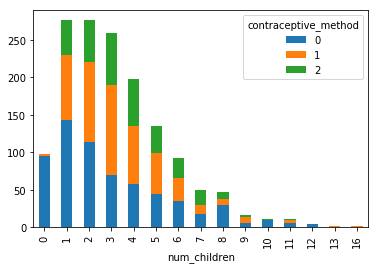

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

data_grouped_by_contraceptive_method = data.groupby(by=["contraceptive_method"])
num_children_by_contraceptive_method = pd.crosstab([data["num_children"]], data.contraceptive_method)

print("Class Distribution")
print(data_grouped_by_contraceptive_method.num_children.count())
print("\nClass Distribution Grouped by Number of Children")
print(num_children_by_contraceptive_method)

num_children_by_contraceptive_method.plot(kind="bar", stacked=True)

The majority of the woman surveyed have 5 or less children. Of note, 2 women had 16 children!

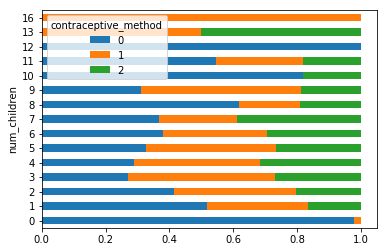

In [5]:
num_children_percentage = num_children_by_contraceptive_method.div(num_children_by_contraceptive_method.sum(axis=1).astype(float),
                             axis=0) # normalize the value

num_children_percentage.plot(kind="barh", stacked=True);

We can see that for wives with 0 children, contraceptive use is almost all "No use". As the number of children increases, we see that families with a smaller amount of children (1-3) start to increase in use of long-term contraceptive use. Similarly, after number of children gets to 3, short term contraceptive usage seems to increase in the percentage of the sampled population. 

One might think that contraceptive use would correspond with having less children, because women on birth control have less kids. However, contraceptive usage might actually be a response to family size. At a certain point, a family might decide their family is too big, and start using contraceptives to avoid their family getting larger. This is just one of many possible explanations for this dataset. 

Another point to take a look at is the use of contraceptives related to education levels and standards of living. According to the paper found here https://www.jstor.org/stable/2138087, women's contraceptive usage tends to increase as their level of education increases. Additionally, a lower standard of living might mean that a women has less access to contraceptives and hence would tend towards "No use". This dataset lines up with that research, but that observation should only be noted, rather be presented as a truth or proof of the research's validity. 

contraceptive_method    0    1    2
sol_index                          
1                      80   40    9
2                     117   82   30
3                     184  157   90
4                     248  232  204


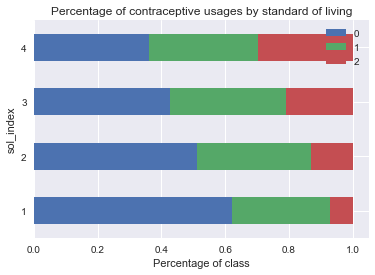

In [57]:
sol = pd.crosstab([data.sol_index], data.contraceptive_method)
print (sol)
# sol_and_education.plot(kind="bar", stacked=True)

sol_percentage = sol.div(sol.sum(axis=1).astype(float),
                             axis=0) # normalize the value

sol_percentage.plot(kind="barh", stacked=True)
plt.title("Percentage of contraceptive usages by standard of living");
plt.xlabel("Percentage of class");
plt.legend()

One thing to note from the table here is the increase in number of women surveyed as their standard of living increases. We can see clearly from this graph that as the standard of living goes up, use of contraceptives goes up. Short term contraceptive use seems to stay constant, but long term contraceptive use goes up. 

Finally, let's look at education and contraceptive use. 

contraceptive_method    0    1    2
wife_education                     
1                     103   40    9
2                     176  121   37
3                     175  155   80
4                     175  195  207


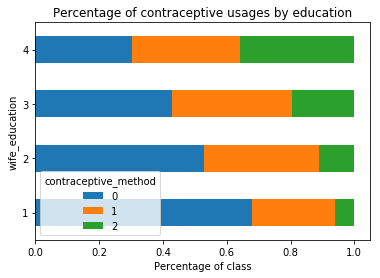

In [7]:
education = pd.crosstab([data.wife_education], data.contraceptive_method)
print (education)
# sol_and_education.plot(kind="bar", stacked=True)

education_percentage = education.div(education.sum(axis=1).astype(float),
                             axis=0) # normalize the value

education_percentage.plot(kind="barh", stacked=True)
plt.title("Percentage of contraceptive usages by education")
plt.xlabel("Percentage of class")

As before, we see that as education level of the woman goes up, "No use" of contraceptive goes down. This is in line with much research on the impact of education on contraceptive use. Again, though, we should note this is only an observation. We cannot say for certain that our dataset is representative, as we did not collect the data. We can only note similarities with it and research. 

Finally, let's see how all of the other variables relate to one another. 

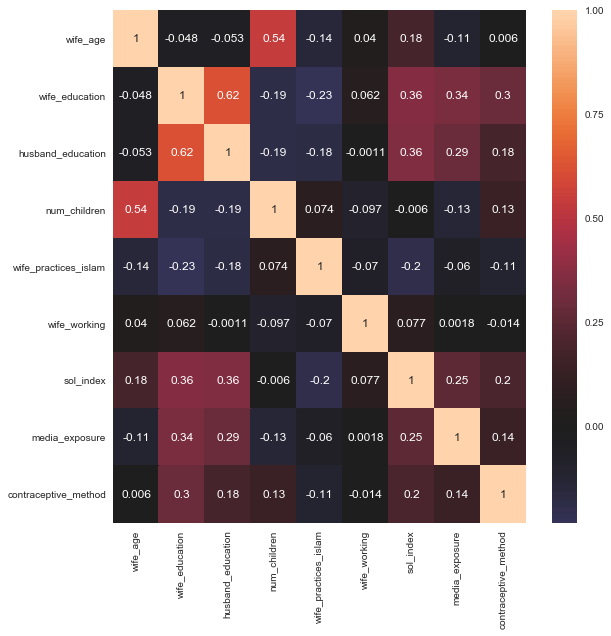

In [58]:
# plot the correlation matrix using seaborn
# cmap = sns.diverging_palette(220, 10, as_cmap=True) 
# sns.set(style="darkgrid") 

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(data.corr(), annot=True, center=0)

f.tight_layout()

From this heatmap we see a few strong correlations. The strongest correlation is that between the husband's education and the wife's education. It would make sense that a couple would tend to have similar education levels, or at least that as one member of the couple trends towards higher education that the other would trend toward higher education. Of course, this cannot be generalized, this is merely the correlation that we are observing. 

Additionally, we see that the next highest correlation is that between wife_age and num_children. Younger women simply haven't had as much time as other women to have children, which might explain the strong correlation. 

Related to contraceptive method, we see that the strongest correlations are with the Standard of Living index, and husband/wife education. These are overall pretty weak correlations, but that doesn't mean that the data cannot be predicted. Correlation measurements measure a linear relationship between variables, and they might not actually have an underlying linear relationship. That's what we will find out with logistic regression. 

### Data Division

We will now split the data into a training set and a testing set. This is also where we will save the one hot encoding of the data. We will use an 80/20 split. This split is appropriate for this specific dataset as each class has a fairly large amount of records associated with it. Because of this, we don't have much of an issue with having enough representative data even though there is almost twice as many 'no use' cases than 'long-term'cases. However, we also don't have very much data so we could have a higher percentage of training data without taking up much time.

In [9]:
X = data.drop("contraceptive_method", axis=1).as_matrix()
y = data["contraceptive_method"]

print(X.shape)
print(y.shape)

(1473, 8)
(1473,)


In [10]:
from sklearn.cross_validation import train_test_split
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
print("Training set has {} instances".format(len(X_train)))
print("Testing set has {} instances".format(len(X_test)))
print("The whole set has {} instances".format(len(X_train) + len(X_test)))

Training set has 1178 instances
Testing set has 295 instances
The whole set has 1473 instances


/Users/jakeoien/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Modeling

### Custom Logistic Regression Classifier

To implement a custom logistic regression classifier, we'll first define the basic classes we'll need and their functions. These were taken from the class notebook on logistic optimization.

In [11]:
import numpy as np
from scipy.special import expit


class BinaryLogisticRegressionBase:
    # private:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    
    def __str__(self):
        return 'Base Binary Logistic Regression Object, Not Trainable'
    
    
    # convenience, private:
    @staticmethod
    def _sigmoid(theta):
        return expit(theta)  # 1/(1+np.exp(-theta)) 
    
    
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    
# inherit from base class
class BinaryLogisticRegression(BinaryLogisticRegressionBase):
    #private:
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'

        
    def _get_gradient(self,X,y):
        # programming \sum_i (yi-g(xi))xi
        gradient = np.zeros(self.w_.shape) # set gradient to zero
        for (xi,yi) in zip(X,y):
            # the actual update inside of sum
            gradi = (yi - self.predict_proba(xi,add_bias=False))*xi 
            # reshape to be column vector and add to gradient
            gradient += gradi.reshape(self.w_.shape) 
        
        return gradient/float(len(y))
       
        
    # public:
    def fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            
            
class VectorBinaryLogisticRegression(BinaryLogisticRegression):
    # inherit from our previous class to get same functionality
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))
    
    
    # but overwrite the gradient calculation
    def _get_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        return gradient.reshape(self.w_.shape)


class LogisticRegression:
    def __init__(self, eta, iterations=20):
        self.eta = eta
        self.iters = iterations
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = VectorBinaryLogisticRegression(self.eta,self.iters)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for blr in self.classifiers_:
            probs.append(blr.predict_proba(X)) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return np.argmax(self.predict_proba(X),axis=1) # take argmax along row

Here we'll define our own logistic regression classifier. We allow for method, cost, and regularization to be passed in as parameters to allow for our classifier to be adjusted and its performance to be examined. We've definied the stochastic gradient descent, newton, and steepest descent methods within our regularized binary logistic regression class.

Our one-versus-all logistic regression classifier is then defined by making use of our regularized binary logistic regression class. In order to make our implementation compatible with GridSearchCV, we'll also implement methods defined by scikit-learn's estimator interface.

In [12]:
from numpy import seterr
from sklearn.metrics import accuracy_score
from numpy.linalg import pinv

np.seterr(over='print')


class RegularizedBinaryLogisticRegression(BinaryLogisticRegression):
    def __init__(self, method="steepest", C=0.1, reg="L1", eta=0.1, **kwargs):
        self.method = method
        self.C = C
        self.reg = reg
        super().__init__(eta=eta, **kwargs)

    def _get_stochastic_gradient(self, X, y):
        idx = int(np.random.rand()*len(y)) # grab random instance
        ydiff = y[idx]-self.predict_proba(X[idx],add_bias=False) # get y difference (now scalar)
        gradient = X[idx] * ydiff[:,np.newaxis] # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        
        
        return gradient
    
    def _get_newton_method_gradient(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        
        return pinv(hessian) @ gradient
    
    def _get_steepest_descent_gradient(self, X, y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
#         gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = np.mean(X * ydiff[:,np.newaxis] + self.C*np.sum(self.w_), axis=0) # make ydiff a column vector and multiply through

        
        return gradient.reshape(self.w_.shape)
    
    def _get_gradient(self, X, y):
        if self.method == "stochastic":
            gradient = self._get_stochastic_gradient(X, y)
        elif self.method == "newton":
            gradient = self._get_newton_method_gradient(X, y)
        elif self.method == "steepest":
            gradient = self._get_steepest_descent_gradient(X, y)
        else:
            return
        
        if self.reg == "L2":
            # derivative of the L2 Norm of the weights, exclude bias term  piecewise function np.sign
            gradient[1:] += -2 * self.w_[1:] * self.C  
        elif self.reg == "L1":
            gradient[1:] += np.sign(self.w_[1:]) * self.C  # exclude bias term
        elif self.reg == "L1L2":
            gradient[1:] += (np.sign(self.w_[1:]) * self.C) + (-2 * self.w_[1:] * self.C)
        else:
            pass
                
        return gradient
        

class RegularizedLogisticRegression(LogisticRegression):
    def __init__(self, eta=0.1, iters=20, method="steepest", C=0.5, reg="L1", **kwargs):
        self.eta = eta
        self.C = C
        self.method = method
        self.reg = reg
        self.iters = iters
        
        super().__init__(eta=eta, iterations=iters, **kwargs)
        
    # methods for estimator interface
    def get_params(self, deep=True):
        return {"method": self.method, "C": self.C, "reg": self.reg}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            self.__setattr__(parameter, value)
        return self
    
    def score(self, X, y):
        y_hat = self.predict(X)
        return accuracy_score(y,y_hat)
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.unique(y) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = [] # will fill this array with binary classifiers
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = y==yval # create a binary problem
            # train the binary classifier for this class
            blr = RegularizedBinaryLogisticRegression(eta=self.eta,
                                                      iterations=self.iters,
                                                      reg=self.reg,
                                                      method=self.method, C=self.C)
            blr.fit(X,y_binary)
            # add the trained classifier to the list
            self.classifiers_.append(blr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T

### Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
y_train = y_train.as_matrix()
y_test = y_test.as_matrix()

In [15]:
accuracies = dict()

methods = ["stochastic",  "steepest"]# , "newton"]
regs = ["L1", "L2", "L1L2", "none"]

C_interval = np.linspace (0.01, 1, 100)

for method in methods:
    for reg in regs:
        name = method + "_" + reg
        print(name)
        accuracies[name] = []
        for C in C_interval:
            rlr = RegularizedLogisticRegression(eta=0.1, reg=reg, method=method, C=C, iters=1000)
            rlr.fit(X_train, y_train)

            yhat = rlr.predict(X_test)
#             print('C: {}'.format(C))
#             print('Accuracy of: ',accuracy_score(y_test,yhat))
#             print('yhat: ',yhat)
#             print()
            accuracies[name].append(accuracy_score(y_test, yhat))

stochastic_L1
stochastic_L2
stochastic_L1L2
stochastic_none
steepest_L1
steepest_L2
steepest_L1L2
steepest_none


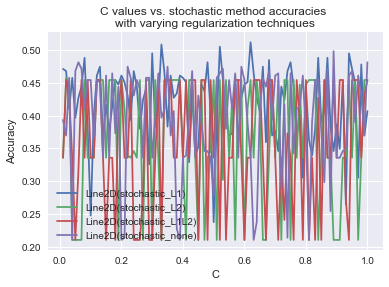

In [16]:
legend = []
method = "stochastic"
for meth_reg in accuracies:
    if method in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

That's a really messy graph. Let's look at L1 as it has the easiest graph to analyze. 

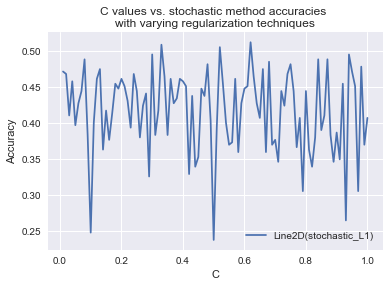

In [17]:
legend = []
method = "stochastic"
for meth_reg in accuracies:
    if "stochastic_L1" == meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      

plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

We can see that in general, C peaks around 0.3 and trends downward after that. Also, as C gets larger, the accuracy jumps around with larger jumps indicating higher variance. We can conclude for stochastic gradient descent with L1 regularization for our test set, smaller C will achieve more reliable accuracy. 

Let's look at how steepest did with these C values. 

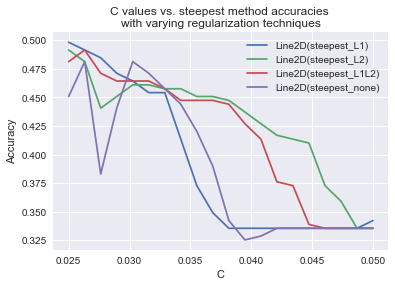

In [32]:
legend = []
method = "steepest"
for meth_reg in accuracies:
    if method in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

They all flatline to the same value it appears. We did some looks at this (outside of the notebook) and found that this was because the model was predicting the same class value always. So with all of the methods, C was too large, as it eventually caused one class to eclipse the others. 

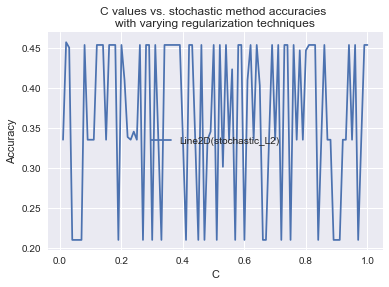

In [20]:
legend = []
method = "stochastic"
for meth_reg in accuracies:
    if "stochastic_L2" == meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      

plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

For L2 on stochastic we see that the accuracy jumps around to the same couple values a lot. This is because the logistic regression function starts to pick all of the same class for its predictions. So changing C doesn't seem to have a consistent effect here other than changing the class that is predicted. 

So, this means that our C value is too large, or our iterations are too large, because the regularization term dominates for a given class. 

Now we look at Newton's method. 

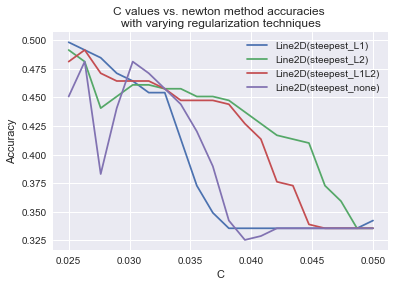

In [33]:
legend = []
method = "newton"
for meth_reg in accuracies:
    if "steepest" in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

After a certain point of steepest descent method, all values of C end up predicting the same class for all instances, same as with steepest descent. So we'll look at smaller values of C. 

In [23]:
accuracies = dict()

methods = ["steepest"]# , "newton"]
regs = ["L1", "L2", "L1L2", "none"]

C_interval = np.linspace (0.0001, 0.05, 100)

for method in methods:
    for reg in regs:
        name = method + "_" + reg
        print(name)
        accuracies[name] = []
        for C in C_interval:
            rlr = RegularizedLogisticRegression(eta=0.1, reg=reg, method=method, C=C, iters=200)
            rlr.fit(X_train, y_train)

            yhat = rlr.predict(X_test)
#             print('C: {}'.format(C))
#             print('Accuracy of: ',accuracy_score(y_test,yhat))
#             print('yhat: ',yhat)
#             print()
            accuracies[name].append(accuracy_score(y_test, yhat))

steepest_L1
steepest_L2
steepest_L1L2
steepest_none


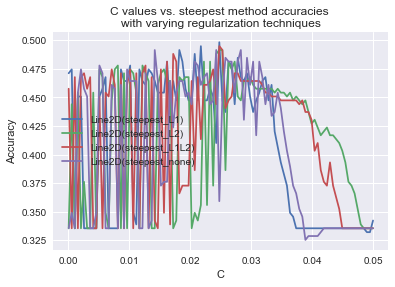

In [24]:
legend = []
method = "steepest"
for meth_reg in accuracies:
    if "steepest" in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

The drastic changes in accuracy stop around 0.025 and stop at 0.05. Let's do it again using those C values. 

In [25]:
accuracies = dict()

methods = ["steepest"]# , "newton"]
regs = ["L1", "L2", "L1L2", "none"]

C_interval = np.linspace (0.025, 0.05, 100)

for method in methods:
    for reg in regs:
        name = method + "_" + reg
        print(name)
        accuracies[name] = []
        for C in C_interval:
            rlr = RegularizedLogisticRegression(eta=0.1, reg=reg, method=method, C=C, iters=200)
            rlr.fit(X_train, y_train)

            yhat = rlr.predict(X_test)
#             print('C: {}'.format(C))
#             print('Accuracy of: ',accuracy_score(y_test,yhat))
#             print('yhat: ',yhat)
#             print()
            accuracies[name].append(accuracy_score(y_test, yhat))

steepest_L1
steepest_L2
steepest_L1L2
steepest_none


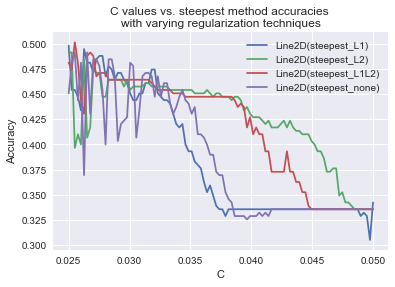

In [26]:
legend = []
method = "steepest"
for meth_reg in accuracies:
    if "steepest" in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

This graph doesn't jump around nearly as much as any of the previous graphs. This might suggest that we have found a value of C that works. For this training set, at least.

We may not be able to find an optimum value of C in the general case, but at least for the training set, we can find that there is some range of C that works well and then drops off as it gets larger. 

In [27]:
accuracies = dict()

methods = ["newton"]# , "newton"]
regs = ["L1"]#, "L2", "L1L2", "none"]

C_interval = np.linspace (0.01, 1, 20)

for method in methods:
    for reg in regs:
        name = method + "_" + reg
        print(name)
        accuracies[name] = []
        for C in C_interval:
            rlr = RegularizedLogisticRegression(eta=0.1, reg=reg, method=method, C=C, iters=200)
            rlr.fit(X_train, y_train)

            yhat = rlr.predict(X_test)
#             print('C: {}'.format(C))
#             print('Accuracy of: ',accuracy_score(y_test,yhat))
#             print('yhat: ',yhat)
#             print()
            accuracies[name].append(accuracy_score(y_test, yhat))

newton_L1


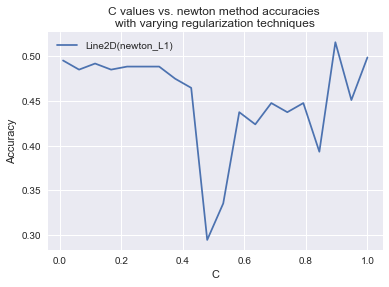

In [28]:
legend = []
method = "newton"
for meth_reg in accuracies:
    if method in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

Let's look at the higher chunk of "good" C values. 0.001 - 0.2

In [29]:
accuracies = dict()

methods = ["newton"]# , "newton"]
regs = ["L1"]#, "L2", "L1L2", "none"]

C_interval = np.linspace (0.025, 0.05, 20)

for method in methods:
    for reg in regs:
        name = method + "_" + reg
        print(name)
        accuracies[name] = []
        for C in C_interval:
            rlr = RegularizedLogisticRegression(eta=0.1, reg=reg, method=method, C=C, iters=200)
            rlr.fit(X_train, y_train)

            yhat = rlr.predict(X_test)
#             print('C: {}'.format(C))
#             print('Accuracy of: ',accuracy_score(y_test,yhat))
#             print('yhat: ',yhat)
#             print()
            accuracies[name].append(accuracy_score(y_test, yhat))

newton_L1


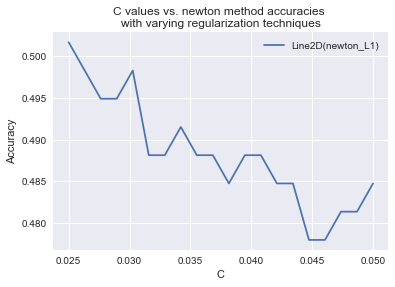

In [30]:
legend = []
method = "newton"
for meth_reg in accuracies:
    if method in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

It seems that a C value between 0.025 and 0.05 is decent (note: by decent we mean not overly jumpy) for all of the test set. Let's look at C between this range for all methods. 

In [31]:
accuracies = dict()

methods = ["newton", "stochastic", "steepest"]
regs = ["L1", "L2", "L1L2", "none"]

C_interval = np.linspace (0.025, 0.05, 20)

for method in methods:
    for reg in regs:
        name = method + "_" + reg
        print(name)
        accuracies[name] = []
        for C in C_interval:
            rlr = RegularizedLogisticRegression(eta=0.1, reg=reg, method=method, C=C, iters=200)
            rlr.fit(X_train, y_train)

            yhat = rlr.predict(X_test)
#             print('C: {}'.format(C))
#             print('Accuracy of: ',accuracy_score(y_test,yhat))
#             print('yhat: ',yhat)
#             print()
            accuracies[name].append(accuracy_score(y_test, yhat))

newton_L1
newton_L2
newton_L1L2
newton_none
stochastic_L1
stochastic_L2
stochastic_L1L2
stochastic_none
steepest_L1
steepest_L2
steepest_L1L2
steepest_none


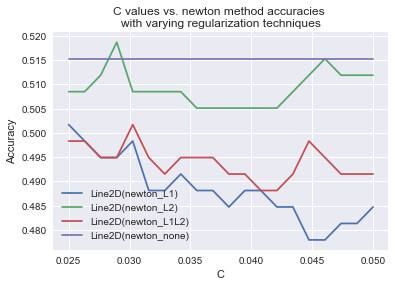

In [34]:
legend = []
method = "newton"
for meth_reg in accuracies:
    if method in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

For none regularization, we had a constant accuracy and actually the highest accuracy of all. the trend of all other reguarizations is that they all have their highest accuracy at C value 0.025. As for L2, the accuracy falls as the C value gets bigger. At given C value, newton's method showed the best performance in prediction.

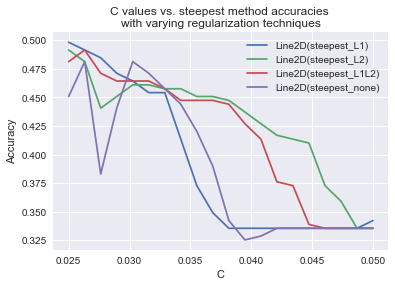

In [35]:
legend = []
method = "steepest"
for meth_reg in accuracies:
    if method in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

While it seems a bit messier than newton's method, steepest showed a relatively consistent trend. We can see that L1 regularization peaks at 0.025 C value and will fall drastically as the C value grows, then become jumpy which indicates decreasing correlation between C value and accuracy. For L2 and none reg, we have a lower accuracy but it quickly rises to their relative peaks. We can also see that past 0.035, the accuracy is in declining trend, rather quickly for none and L1 regularization.

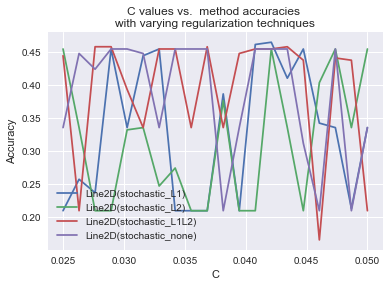

In [37]:
legend = []
method = ""
for meth_reg in accuracies:
    if "stochastic" in meth_reg:
        handle, = plt.plot(C_interval, accuracies[meth_reg], label=meth_reg)
        legend.append(handle)
      
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("C values vs. " + method + " method accuracies \nwith varying regularization techniques")
plt.legend(legend);

The most problematic of all, the accuracy for stochastic gradient descent showed insignificant correlation with the C value. And the range of C values were unreliable not only due to the inconsistency but the minimum accuracy being the lowest of all methods. This could mean that more iterations are required to shore up the accuracy. However, the accuracy is jumping to the same values a lot, which means the predictions are all of the same class again. For our given setup, stochastic descent doesn't appear to be our best bet. 

Overall, the newton method with L1 regularization proved to be most effective on our test set. 

#### Discussion

Our method of selecting parameters was definitely highly tuned to our test set. As far as data snooping goes, we are definitely culprits of it. We used one test set to find the best method that would fit our test set. In the general case, we would not expect the model to perform well. It might happen to perform well, and it might not. Kind of a toss-up, really. However, with more sophisticated techniques one might be able to more robustly come up with the proper parameters for the general case. These techniques would be something like cross-validation, for example. 

### Comparison

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.2 µs
Our Time:  2.4287850856781006
Accuracy:  0.501694915254
CPU times: user 8 µs, sys: 2 µs, total: 10 µs
Wall time: 6.2 µs
Scikit Time:  0.009005069732666016
Scikit Score:  0.508474576271


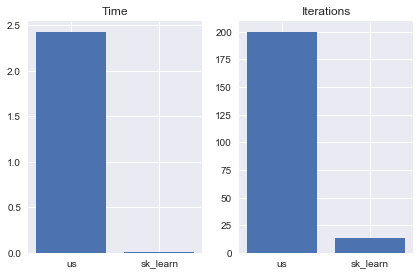

In [48]:
from sklearn.linear_model import LogisticRegression as SKLogisticRegression
import time

%time

start = time.time()
rlr = RegularizedLogisticRegression(eta=0.1,iters=200, reg='L1',
                                   method='newton',C=0.025)

rlr.fit(X_train, y_train)
score = rlr.score(X_test, y_test)
end = time.time()
our_time = end - start

print("Our Time: ", our_time)
print("Accuracy: ",score)



%time

start = time.time()

lr_sk = SKLogisticRegression()
lr_sk.fit(X_train, y_train)
sk_score = lr_sk.score(X_test, y_test)

end = time.time()
sk_time = end - start
print("Scikit Time: ", sk_time)
print("Scikit Score: ", sk_score)

fig, axes = plt.subplots(nrows=1, ncols=2)
plt.setp(axes, xticks=[0, 1], xticklabels=['us', 'sk_learn'])

y_axis = [our_time, sk_time]
x_axis = [0, 1]
plt.sca(axes[0])
plt.bar(x_axis, y_axis)
axes[0].set_title('Time')

plt.sca(axes[1])
y_axis = [200, lr_sk.n_iter_]
x_axis = [0, 1]
plt.bar(x_axis, y_axis)
axes[1].set_title('Iterations')



plt.tight_layout()
plt.show()

In [47]:
print(lr_sk.n_iter_)

[13]


### Deployment

The scores: <br>
Us: 0.501694915254<br>
SK_learn: 0.508474576271

We have two problems with our method : time and optimization.

Interestingly, our model was able to achieve similar accuracy results to sklearn. However, it took significantly longer to get those results. Sklearn also performed many less iterations than we did. Additionally, sklearn also has much more rich functionality and is more generalized and robust. Given that we have similar accuracy scores, and sklearn has been vetted by countless data scientists, that would be one reason to prefer sklearn over our model. 

Also, the parameters of the method is highly optimized for this dataset and this size. We have not tested our method on any other dataset, much less a larger dataset. That being said, we believe the reliability and general flexibilty of scikit learn is much better than our method right now. 

As far as our success goes, we would not say this is a success. The accuracy is going to be affected by class imbalances, and we would not be confident in recommending our model to be used for our business case of advertising. Overall, a more sophisticated machine learning model might be required to more accurately predict a woman's contraceptive use, or at least more data points collected. 

## Grid Search CV

for exceptional work, we implemented our regression to work with sklearn's GridSearchCV function.

In [42]:
#code from 
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#Examples section
from sklearn.model_selection import GridSearchCV
params = {'method':('steepest', 'stochastic', 'newton'),'C':[0.025], 'eta':[0.1], 'iters':[200]}
rlr = RegularizedLogisticRegression()
clf = GridSearchCV(rlr, params)
clf.fit(X_train,y_train)
#instead of printing, make it look clean using df
pd.DataFrame(clf.cv_results_)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_eta,param_iters,param_method,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.058370,0.000366,0.486418,0.484298,0.025,0.1,200,steepest,"{'C': 0.025, 'eta': 0.1, 'iters': 200, 'method...",2,0.529262,0.475159,0.447837,0.499363,0.482143,0.478372,0.002463,0.000117,0.033392,0.010733
1,0.010173,0.000234,0.366723,0.382836,0.025,0.1,200,stochastic,"{'C': 0.025, 'eta': 0.1, 'iters': 200, 'method...",3,0.381679,0.341401,0.300254,0.384713,0.418367,0.422392,0.000017,0.000004,0.049357,0.033091
2,1.100702,0.000302,0.488115,0.477504,0.025,0.1,200,newton,"{'C': 0.025, 'eta': 0.1, 'iters': 200, 'method...",1,0.486005,0.481529,0.508906,0.472611,0.469388,0.478372,0.009501,0.000006,0.016199,0.003692


It's really easy to compare the pros and cons of the methods! We have experienced and struggled with the ridiculous fit time of the newton's method, and it does give us the best prediction. Looking at this result, it may be better for us to use the steepest gradient descent in terms of cost benefit analysis. However, a pivot should likely be done, as it does not seem that parameter tuning will affect our accuracy any better. Another avenue could be more feature collection so as to have a larger list of things to compare contraceptive use to. 

In any event, logistic regression doesn't seem to stick out as the way to go to solve this problem, at least until more work can be done with the dataset. 